<h1>Load dependencies</h1>

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import math
import numpy as np
import pandas as pd

Using TensorFlow backend.


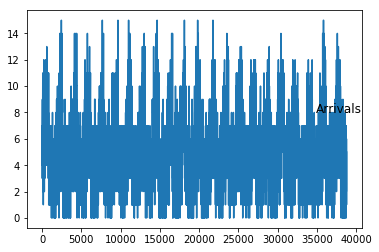

In [2]:
###############################################################################
# Explore data
###############################################################################

outputfile='/Users/mikeriess/Desktop/Ikea_Case/SimulatedData.csv'


from matplotlib import pyplot
# load dataset
dataset = read_csv(outputfile, header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [1]
i = 1


# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [3]:
###############################################################################
# Function for data tranformation
###############################################################################
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [4]:
###############################################################################
# Data prep
###############################################################################    

"""
Predict the next 2 hours based on demand the current day.

=> This should be defined by the business problem; Staffing plan.
    => Objective is to minimize ques.
        => Assume that some workers can be sent home during the day (?)  
"""

# load dataset
dataset = read_csv('/Users/mikeriess/Desktop/Ikea_Case/SimulatedData.csv', header=0, index_col=0)#dataset = dataset.drop('Weekday', 1)
#print(dataset.head())
just_dummies = pd.get_dummies(dataset['Weekday'])

dataset = pd.concat([dataset, just_dummies], axis=1)      
dataset.drop(['Weekday'], inplace=True, axis=1)

#print(dataset.head())

In [5]:
values = dataset.values
#print(values[:10])

# integer encode direction
encoder = LabelEncoder()
values[:,0] = encoder.fit_transform(values[:,0]) #TARGET VARIABLE

# ensure all data is float
values = values.astype('float32')

#dataset.head()

In [6]:
X = dataset["Arrivals"]
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
#print(X_std)
X_scaled = X_std * (1 - 0) + 0
#print(X_scaled)

In [7]:
minimas=[]
maximas=[]
varnames=[]

newdata = dataset

#X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
#X_scaled = X_std * (max - min) + min


#RANGE TRANSFORMATION
for column in dataset:
    #standardize
    minima=np.min(dataset[column])
    maxima=np.max(dataset[column])
    #mean=np.mean(dataset[column])
    #sdev=np.std(dataset[column])
    
    X = dataset[column]
    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    newdata[column] = X_std * (1 - 0) + 0
    
    #newdata[column]=((dataset[column]-mean)/sdev)* (1 - 0) + 0
    
    #store the values
    minimas.append(minima)
    maximas.append(maxima)
    varnames.append(column)
    #print(np.max(newdata[column]))
    
#Generate table
Transformations = pd.DataFrame(
    {'column': varnames,
     'mini': minimas,
     'maxi': maximas
    })
print(Transformations.head())
print(newdata.head())

          column       maxi      mini
0       Interval  60.000000  1.000000
1       Arrivals  15.000000  0.000000
2  Checkouttimes  17.571827  0.191915
3         Fredag   1.000000  0.000000
4         Lørdag   1.000000  0.000000
            Interval  Arrivals  Checkouttimes  Fredag  Lørdag  Mandag  Onsdag  \
Date                                                                            
2016-01-01  0.000000  0.266667       0.226284     1.0     0.0     0.0     0.0   
2016-01-01  0.000000  0.266667       0.160618     1.0     0.0     0.0     0.0   
2016-01-01  0.000000  0.266667       0.143165     1.0     0.0     0.0     0.0   
2016-01-01  0.000000  0.266667       0.082163     1.0     0.0     0.0     0.0   
2016-01-01  0.016949  0.400000       0.083560     1.0     0.0     0.0     0.0   

            Tirsdag  Torsdag  
Date                          
2016-01-01      0.0      0.0  
2016-01-01      0.0      0.0  
2016-01-01      0.0      0.0  
2016-01-01      0.0      0.0  
2016-01-01      0.

In [8]:
#Normalization procedure
scaled = newdata.values

# frame as supervised learning: Predict next hour (6X1 obs) using last 6 hours (6X6 obs)
reframed = series_to_supervised(scaled, n_in=6, n_out=6, dropnan=True)
reframed = pd.DataFrame(reframed)
print(reframed[:2])
print(len(reframed))

# drop columns we don't want to predict => all t+variables which is not the target
#Target == var2

reframed.drop(["var1(t+5)","var3(t+5)","var4(t+5)","var5(t+5)","var6(t+5)","var7(t+5)","var8(t+5)","var9(t+5)",
              "var1(t+4)","var3(t+4)","var4(t+4)","var5(t+4)","var6(t+4)","var7(t+4)","var8(t+4)","var9(t+4)",
              "var1(t+3)","var3(t+3)","var4(t+3)","var5(t+3)","var6(t+3)","var7(t+3)","var8(t+3)","var9(t+3)",
              "var1(t+2)","var3(t+2)","var4(t+2)","var5(t+2)","var6(t+2)","var7(t+2)","var8(t+2)","var9(t+2)",
              "var1(t+1)","var3(t+1)","var4(t+1)","var5(t+1)","var6(t+1)","var7(t+1)","var8(t+1)","var9(t+1)",
              "var1(t)","var3(t)","var4(t)","var5(t)","var6(t)","var7(t)","var8(t)","var9(t)"], inplace=True, axis=1)

print(reframed[:2])
#print(reframed.head())

   var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
6        0.0   0.266667   0.226284        1.0        0.0        0.0   
7        0.0   0.266667   0.160618        1.0        0.0        0.0   

   var7(t-6)  var8(t-6)  var9(t-6)  var1(t-5)    ...      var9(t+4)  \
6        0.0        0.0        0.0        0.0    ...            0.0   
7        0.0        0.0        0.0        0.0    ...            0.0   

   var1(t+5)  var2(t+5)  var3(t+5)  var4(t+5)  var5(t+5)  var6(t+5)  \
6   0.033898   0.466667   0.181895        1.0        0.0        0.0   
7   0.033898   0.466667   0.329821        1.0        0.0        0.0   

   var7(t+5)  var8(t+5)  var9(t+5)  
6        0.0        0.0        0.0  
7        0.0        0.0        0.0  

[2 rows x 108 columns]
38750
   var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
6        0.0   0.266667   0.226284        1.0        0.0        0.0   
7        0.0   0.266667   0.160618        1.0        0.0        0.0   

   

In [9]:
# split into train and test sets
values = reframed.values
n_train_hours = int(np.floor(values.shape[0]/2)) #180*8*6 #half a year, 8 hours a day, 6x10 minutes per hour .... ish

train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [10]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

((19375, 1, 59), (19375,), (19375, 1, 59), (19375,))


<h2>Train the model:</h2>

Train on 19375 samples, validate on 19375 samples
Epoch 1/20
3s - loss: 0.2128 - val_loss: 0.1289
Epoch 2/20
2s - loss: 0.1184 - val_loss: 0.1123
Epoch 3/20
2s - loss: 0.1083 - val_loss: 0.1041
Epoch 4/20
2s - loss: 0.0968 - val_loss: 0.0900
Epoch 5/20
2s - loss: 0.0839 - val_loss: 0.0759
Epoch 6/20
2s - loss: 0.0768 - val_loss: 0.0726
Epoch 7/20
2s - loss: 0.0755 - val_loss: 0.0768
Epoch 8/20
2s - loss: 0.0700 - val_loss: 0.0648
Epoch 9/20
2s - loss: 0.0670 - val_loss: 0.0672
Epoch 10/20
2s - loss: 0.0674 - val_loss: 0.0688
Epoch 11/20
2s - loss: 0.0644 - val_loss: 0.0603
Epoch 12/20
2s - loss: 0.0628 - val_loss: 0.0586
Epoch 13/20
2s - loss: 0.0639 - val_loss: 0.0640
Epoch 14/20
2s - loss: 0.0610 - val_loss: 0.0595
Epoch 15/20
2s - loss: 0.0602 - val_loss: 0.0553
Epoch 16/20
2s - loss: 0.0613 - val_loss: 0.0607
Epoch 17/20
2s - loss: 0.0584 - val_loss: 0.0572
Epoch 18/20
2s - loss: 0.0578 - val_loss: 0.0543
Epoch 19/20
2s - loss: 0.0595 - val_loss: 0.0602
Epoch 20/20
2s - loss: 0.056

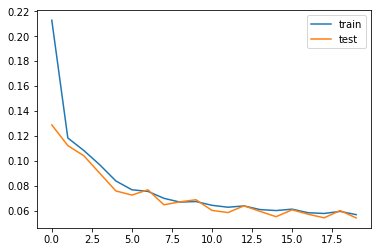

In [11]:
###############################################################################
# Model design & training
###############################################################################
 
# design network
model = Sequential()
model.add(LSTM(1, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, 
                    epochs=20, 
                    batch_size=75, 
                    validation_data=(test_X, test_y), 
                    verbose=2, 
                    shuffle=False) #false

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

<h2>Prediction</h2>

In [12]:
periods = 2*6 #Predict next 2 hours (6X2 obs) using last 6 hours (6X6 obs)

test_prediction = test_X[:periods]

# make a prediction
yhat = model.predict(test_prediction)

# frame as supervised learning
y = test_y[:periods]

print("Yhat=")
print(yhat[:10])
print("y=")
print(y[:10])

Yhat=
[[ 0.55599433]
 [ 0.56171978]
 [ 0.56459928]
 [ 0.60917372]
 [ 0.62776649]
 [ 0.63493603]
 [ 0.63539702]
 [ 0.63345391]
 [ 0.62740791]
 [ 0.62720543]]
y=
[ 0.53333333  0.53333333  0.6         0.6         0.6         0.6         0.6
  0.6         0.6         0.6       ]


<h2>Evaluation: normalized</h2>

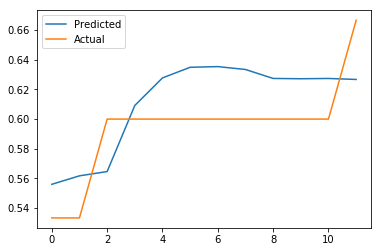

In [15]:
#Plot the first predicted values
pyplot.plot(yhat, label="Predicted")
pyplot.plot(y, label="Actual")
pyplot.legend()
pyplot.show()

In [16]:
#Rescale the numbers back into their real values;

#Z BACKTRANSFORM: GENERIC
#for index, row in Transformations.iterrows():
#    var = row['column']
#    mini = row["mini"]
#    maxi = row["maxi"]
    #back-transform: x = std*z + m
#    X = newdata[var]
#    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
#    newdata[var] = X_std * (maxi - mini) + mini
    
#Debugging;
#print(dataset.head())
#print(newdata.head())

In [17]:
# Backtransformation for y and yhat

Ytrans = Transformations.loc[Transformations['column'] == "Arrivals"]

#Z BACKTRANSFORM
for index, row in Ytrans.iterrows():
    mini = row["mini"]
    maxi = row["maxi"]
    #back-transform:
    X = yhat
    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    yhat_new = X_std * (maxi - mini) + mini
    
    X = y
    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    y_new = X_std * (maxi - mini) + mini

#Convert to integer:
yhat_new = np.floor(yhat_new)
y_new = np.floor(y_new)

<h2>Evaluation: Original scale</h2>

('MSE =', 55.833333333333336)
('RMSE =', 7.4721705904866313)
('MAE =', 6.708333333333333)


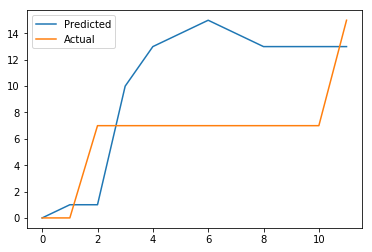

In [18]:
#Calculating evaluation metrics
MSE = np.mean((y_new-yhat_new)**2)
print("MSE =",MSE)
RMSE = np.sqrt(MSE)
print("RMSE =",RMSE)
MAE = np.mean(np.abs(y_new-yhat_new))
print("MAE =",MAE)

pyplot.plot(yhat_new, label="Predicted")
pyplot.plot(y_new, label="Actual")
pyplot.legend()
pyplot.show()

<h1>Generate staffing plan </h1>
This part will now attempt to generate a staffing plan that satisfies the predicted number of customers.

In [19]:
#Load the package
from pulp import *
#Store the results:
import pandas as pd

def make_workplan(Expected_customers):

    #Load the predicted amount of customers
    LSTM_Prediction = Expected_customers
    
    #Make problem:
    prob = LpProblem("IKEA_CHECKOUT",LpMinimize)
    
    #Setup decision variables
    SD1=LpVariable('ServiceDesk1', cat='Binary')
    SD2=LpVariable('ServiceDesk2', cat='Binary')
    SD3=LpVariable('ServiceDesk3', cat='Binary')
    SD4=LpVariable('ServiceDesk4', cat='Binary')
    SD5=LpVariable('ServiceDesk5', cat='Binary')
    SD6=LpVariable('ServiceDesk6', cat='Binary')
    SD7=LpVariable('ServiceDesk7', cat='Binary')
    SD8=LpVariable('ServiceDesk8', cat='Binary')
    SD9=LpVariable('ServiceDesk9', cat='Binary')
    SD910=LpVariable('ServiceDesk910', cat='Binary')
    SD911=LpVariable('ServiceDesk911', cat='Binary')
    SD912=LpVariable('ServiceDesk912', cat='Binary') 
    SD913=LpVariable('ServiceDesk913', cat='Binary') 
    SD914=LpVariable('ServiceDesk914', cat='Binary') 
    SD915=LpVariable('ServiceDesk915', cat='Binary') #Special desk
    
    # The objective function: Minimize costs
    prob += 20*SD1 + 20*SD2 + 20*SD3 + 20*SD4 + 20*SD5 + 20*SD6 + 20*SD7 + 20*SD8 + 20*SD9 + 20*SD910 + 20*SD911 + 20*SD912 + 20*SD913 + 20*SD914 + 20*SD915, "Cost per 10 minutes"

    #Subject to; Capacity of each cash-out service desk
    prob += 20*SD1 + 20*SD2 + 20*SD3 + 20*SD4 + 20*SD5 + 20*SD6 + 20*SD7 + 20*SD8 + 20*SD9 + 20*SD910 + 20*SD911 + 20*SD912 + 20*SD913 + 20*SD914 + 20*SD915 >= LSTM_Prediction, "Forecasted_Customers"
    
    # The problem data is written to an .lp file
    prob.writeLP("IKEA_CASHOUT.lp")
    
    #Solve
    prob.solve()
    
    # The status of the solution is printed to the screen
    print("Status:", LpStatus[prob.status])
    
    # The optimised objective function value is printed to the screen
    print("Total labor Cost the next 10 minutes = ", value(prob.objective))
    listvar = []
    listval = []

    for v in prob.variables():
        listvar.append(v.name)
        listval.append(v.varValue)
        print(v.name, "=", v.varValue)
    
    #Store a DF
    StaffingPlan = pd.DataFrame(
    {'ServiceDesk': listvar,
     'Open': listval
    })
    
    StaffingPlan.head()
    return(StaffingPlan)

In [20]:
#Test the function
#Test_res = make_workplan(100)
#Test_res.head()

In [21]:
print(yhat_new[:12])


[[  0.]
 [  1.]
 [  1.]
 [ 10.]
 [ 13.]
 [ 14.]
 [ 15.]
 [ 14.]
 [ 13.]
 [ 13.]
 [ 13.]
 [ 13.]]


In [22]:
#set up the list of forecasted values;
LSTM_Forecast = np.floor(yhat_new)*10
Results = []

for i in LSTM_Forecast:
    print(i)
    Test_res = make_workplan(i)
    Results.append(Test_res)
    
# Convert the list into a df;
appended_data = pd.concat(Results, axis=0)

#Inspect the results:
appended_data[:30]

appended_data.to_csv(path_or_buf="StaffingPlan.csv", sep=',')

[ 0.]
('Status:', 'Optimal')
('Total labor Cost the next 10 minutes = ', 0.0)
('ServiceDesk1', '=', 0.0)
('ServiceDesk2', '=', 0.0)
('ServiceDesk3', '=', 0.0)
('ServiceDesk4', '=', 0.0)
('ServiceDesk5', '=', 0.0)
('ServiceDesk6', '=', 0.0)
('ServiceDesk7', '=', 0.0)
('ServiceDesk8', '=', 0.0)
('ServiceDesk9', '=', 0.0)
('ServiceDesk910', '=', 0.0)
('ServiceDesk911', '=', 0.0)
('ServiceDesk912', '=', 0.0)
('ServiceDesk913', '=', 0.0)
('ServiceDesk914', '=', 0.0)
('ServiceDesk915', '=', 0.0)
[ 10.]
('Status:', 'Optimal')
('Total labor Cost the next 10 minutes = ', 20.0)
('ServiceDesk1', '=', 0.0)
('ServiceDesk2', '=', 0.0)
('ServiceDesk3', '=', 0.0)
('ServiceDesk4', '=', 0.0)
('ServiceDesk5', '=', 0.0)
('ServiceDesk6', '=', 0.0)
('ServiceDesk7', '=', 0.0)
('ServiceDesk8', '=', 0.0)
('ServiceDesk9', '=', 0.0)
('ServiceDesk910', '=', 0.0)
('ServiceDesk911', '=', 0.0)
('ServiceDesk912', '=', 0.0)
('ServiceDesk913', '=', 0.0)
('ServiceDesk914', '=', 0.0)
('ServiceDesk915', '=', 1.0)
[ 10.]
(